# Testing Navier-Stokes in package `ViscousFlow`

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Non-linear term basic calculation

In [3]:
using Random

In [4]:
Random.seed!(1);

In [5]:
nx = 129; ny = 129;
w = Nodes(Dual,(nx,ny))
w .= rand(Float64,size(w));
Qq = Edges(Dual,w);
Ww = deepcopy(Qq);
ψ = deepcopy(w);

In [6]:
L = plan_laplacian(w,with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 129, ny = 129) grid with spacing 1.0

In [8]:
@time nl = divergence(cellshift!(Qq,curl(L\w))∘cellshift!(Ww,w));

  0.002667 seconds (20 allocations: 776.844 KiB)


### Solve the Lamb-Oseen vortex

First, construct the exact solution

In [9]:
woseen(x::Tuple{Real,Real},t;Re=1.0,x0::Tuple{Real,Real}=(0,0),t0=1) = 
                            exp(-((x[1]-x0[1])^2+(x[2]-x0[2])^2)/(4(t+t0)/Re))/(1+t/t0)

woseen (generic function with 1 method)

In [10]:
Re = 200 + 50rand()
U = 1.0 + 0.2randn()
U∞ = (U,0.0)
Δx = 0.015;
Δt = min(0.5*Δx,0.5*Δx^2*Re);
xlim = (0.0,3.0);
ylim = (0.0,2.0);

Construct exact solution in shape of grid data

In [11]:
sys = Systems.NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞)

Navier-Stokes system on a grid of size 202 x 136

In [12]:
w₀ = Nodes(Dual,size(sys));

In [13]:
xg,yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))
x0 = (1.0,1.0); t0 = 1;
wexact(t) = [woseen((x,y),t;Re=Re,x0=x0.+U∞.*t,t0=t0) for x in xg, y in yg]

wexact (generic function with 1 method)

In [14]:
ifrk = IFRK(w₀,sys.Δt,
                (t,w) -> Systems.plan_intfact(t,w,sys),
                (w,t) -> Systems.r₁(w,t,sys) ,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Nodes{Dual,202,136}
   Time step size 0.0075


In [15]:
t = 0.0
w₀ .= wexact(t)
w = deepcopy(w₀)
tf = 1.0
T = 0:Δt:tf;

In [16]:
t = 0.0;
for ti in T
    global t, w = ifrk(t,w)
end

In [17]:
using LinearAlgebra

In [18]:
LinearAlgebra.norm(w-wexact(t),Inf)

0.0011706795352829369

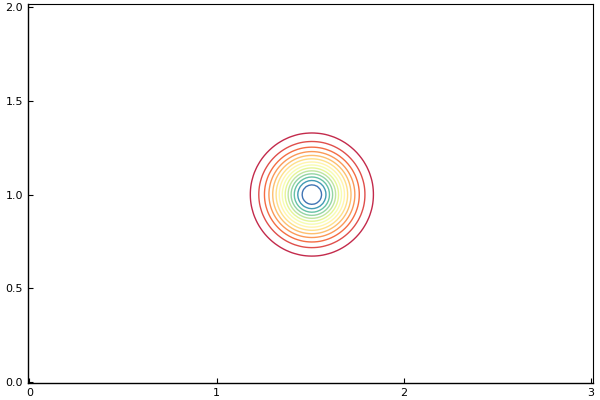

In [19]:
plot(xg,yg,w)

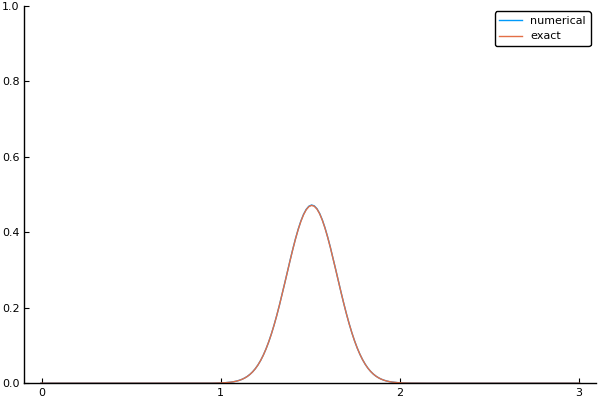

In [20]:
plot(xg,w[:,65],label="numerical",ylim=(0,1))
plot!(xg,wexact(t)[:,65],label="exact")